<a href="https://colab.research.google.com/github/aldo-arevalo/mimic-code/blob/master/notebooks/ICUglycemia/Notebooks/2_0_ara_pairing_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data extraction and Pairing of Insulin Inputs to Glucose Measurements in the ICU
## Interactive notebook: Part II

Authors: [Aldo Robles Arévalo](mailto:aldo.arevalo@tecnico.ulisboa.pt); Jason Maley; Lawrence Baker; Susana M. da Silva Vieira; João M. da Costa Sousa; Stan Finkelstein; Jesse D. Raffa; Roselyn Cristelle; Leo Celi; Francis DeMichele

## Overview

This notebook contains the pairing of pre-processed glucose readings and insulin inputs from  the Medical Information Mart for Intensive Care (MIMIC).The curation is detailed in *1.0-ara-data-curation-I.ipynb*.

## General instructions
To perform the queries, do not forget to specify your project ID that grants you access to the MIMIC database hosted in *bigQuery*. Substitute `projectid` variable with the name of that project. In case you want to save the dataframes to your *BigQuery* project, uncomment and substitute `your_dataset` with the name of your *BigQuery* dataset and execute.

You can also save the created dataframes and figures in your Google Drive account. After mounting your drive, substitute `base_dir` variable with the path of the folder where you want to save them. In this notebook that folder was named `Insulin Therapy ICU` and `MyDrive` is the parent folder. Figures are saved in the path *Insulin Therapy ICU/DataExtraction/MIMIC_III/Figures/*, you should change it according to your needs or create the folders with the exact names in your Google Drive.

## Pairing rules
Once merged the insulin inputs and glucose readings from the *1.0-ara-data-curation-I.ipynb* notebok, now we continue with the **pairing** of an insulin event with a preceding glucose reading.

The goal is to link each insulin dose with the nearest glucose measurement. For this complex task, the following rules were implemented. This operation is done in BigQuery. The following rules or assumptions are proposed:

1. **Rule 1**: A glucose reading should precede a regular insulin administration by up to 90 minutes. This basis for this time window is derived from the diabetic ketoacidosis guidelines which recommend measuring glucose values every 60 minutes while receiving an insulin infusion. An additional 30 minutes were added, 90 minutes in total, to this interval to account for the time it may take for providers to register the event. 
2. **Rule 2**: When a regular insulin event is not preceded, but instead followed, by a blood glucose measurement, this glucose reading is paired with the regular insulin administration if they are recorded within 90 minutes of each other.
3. **Rule 3**: Sometimes a regular insulin infusion/bolus appears between 2 blood glucose measurements. In this case, the higher glucose value is paired with the regular insulin entry as long as they are entered within 90 minutes of each other.
4. **Rule 4**: When a regular insulin bolus occurs very close to a regular insulin infusion rate, it is assumed that the patient was given a bolus and then commenced on an infusion. Both regular insulin entries are paired with the preceding blood glucose measurement, or the posterior glucose reading in case its value is higher than the preceding blood glucose and is entered within 90 minutes of the insulin dose.
5. No glucose values below 90 mg/dL is paired with a subsequent regular insulin bolus or infusion. No clinician will treat this low of a blood glucose value with a regular insulin bolus or infusion.

# Code

## Import dependencies and libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from scipy import stats
from datetime import datetime
import time
import warnings

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing data using Google BigQuery.
from google.cloud import bigquery
from google.colab import files, auth
auth.authenticate_user()
print('Authenticated')
%load_ext google.colab.data_table

# Function to submit query to BigQuery
def q(query,projectid):
    client = bigquery.Client(location="US",project=projectid)
    # Location must match that of the dataset(s) referenced in the query.
    query_job = client.query(query,
    location="US",)
    return query_job.to_dataframe()

#Rounding (for heatmap categories)
def myround(x, base):
    return int(base * round(float(x)/base))

def convert_to_datetime(df,time_cols):
    for t_col in time_cols:
        df[t_col] = pd.to_datetime(df[t_col])
    
    return(df)

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# Select your own folder
base_dir = "/content/gdrive/My Drive/Insulin Therapy ICU"

## Adjusted datasets

* **Note 1**: Substitute `your_dataset` with the name of your dataset ID (Line 850) where you hosted/stored the tables created in the `1.0-ara-pairing-I.ipynb` notebook. 
* **Note 2**: The table `glucose_insulin_ICU` was created in `1.0-ara-pairing-I.ipynb` notebook. It is equivalent to `glucose_insulin_ICU.csv`.

In [ ]:
# Import dataset adjusted or aligned
projectid = "YOUR_PROJECT_ID" # <-- Add your project ID

query ="""
WITH pg AS(
    SELECT p1.*

    -- Column GLC_AL that would gather paired glucose values according to the proposed rules
    ,(CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings, select the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLC,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another insulin event
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the POSTERIOR glucose (1 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))

        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLC_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column GLCTIMER_AL that would gather the timestamp of the paired glucose reading
    , (CASE 
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.TIMER,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the timestamp of the POSTERIOR glucose (1 rows below) measurement that gathers the 
        -- previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCTIMER_AL

    -- -----------------------------------------------------------------------------------------------
    -- Column GLCSOURCE_AL that would indicate whether is fingerstick or lab analyzer sample of 
    -- the paired glucose reading
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLCSOURCE,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the whether is figerstick or lab analyzer the POSTERIOR glucose (1 rows below) measurement 
        -- that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCSOURCE_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column RULE that indicateS which pairing rule is applied for the i^th case
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

            -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 3
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 90
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN 4

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 90)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the Rule number applied
        THEN 2
        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS RULE

    FROM `your_dataset.glucose_insulin_ICU` AS p1
    WINDOW w AS(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
)

-- Create a colum that identifies the glucose readings were paired and are duplicated in pg
SELECT pg.*
, (CASE
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LEAD(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          THEN 1 
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LAG(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          AND LAG(endtime,1) OVER(x) IS NOT null 
          THEN 1
          ELSE null END) AS Repeated
FROM pg
WINDOW x AS(PARTITION BY ICUSTAY_ID ORDER BY pg.timer)
"""

ICUinputs_adjusted = q(query,projectid)

del query

# Convert dtypes
ICUinputs_adjusted[["Repeated","INFXSTOP","RULE"]] = ICUinputs_adjusted[
        ["Repeated","INFXSTOP","RULE"]].apply(pd.to_numeric, errors='coerce')

# Remove values that are repeated due to the SQL query
ICUinputs_adjusted = ICUinputs_adjusted[ICUinputs_adjusted['Repeated']!=1]

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(ICUinputs_adjusted.shape[0]))
print("Patients: {}".format(ICUinputs_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICUinputs_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(ICUinputs_adjusted['ICUSTAY_ID'].nunique()))

# Rules
display(HTML('<h5>Frequency of the rules</h5>'))
print(ICUinputs_adjusted['RULE'].value_counts())

Entries: 496200
Patients: 9518
Hospital admissions: 11094
ICU stays: 12210


1.0    86913
2.0     8841
4.0     8683
3.0     5574
Name: RULE, dtype: int64


### Boluses of short-acting insulin

In [ ]:
# Filtering for only short insulin boluses and all sources of glucose
short_BOL_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Short") & 
        (ICUinputs_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(short_BOL_adjusted.shape[0]))
print("Patients: {}".format(short_BOL_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_BOL_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(short_BOL_adjusted['ICUSTAY_ID'].nunique()))

display(short_BOL_adjusted[['INPUT','GLC_AL']].describe())

# Save as CSV file, uncomment and modify as needed.
# short_BOL_adjusted.to_csv(base_dir+"/DataExtraction/BolusesCUR.csv", index=False, 
#                          encoding='utf8', header = True)

Entries: 88460
Patients: 9370
Hospital admissions: 10877
ICU stays: 11484


,INPUT,GLC_AL
count,88460.000000,71457.000000
mean,4.517858,187.719048
std,3.038148,58.226197
min,0.100000,90.000000
25%,2.000000,150.000000
50%,4.000000,173.000000
75%,6.000000,211.000000
max,17.000000,901.000000


In [ ]:
# Aligned and not aligned entries
display(HTML('<h2>Boluses entries of short-acting insulin<h2>'))
print("Entries that were aligned: {}".format(
    short_BOL_adjusted.shape[0]-short_BOL_adjusted.loc[np.isnan(
        short_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Entries that weren't aligned: {}".format(
    short_BOL_adjusted.loc[np.isnan(short_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Non-paired percentage: {:0.2f}%".format(
    short_BOL_adjusted.loc[np.isnan(
        short_BOL_adjusted.RULE),'RULE'].shape[0]/short_BOL_adjusted.shape[0]*100))

Entries that were aligned: 71455
Entries that weren't aligned: 17005
Non-paired percentage: 19.22%


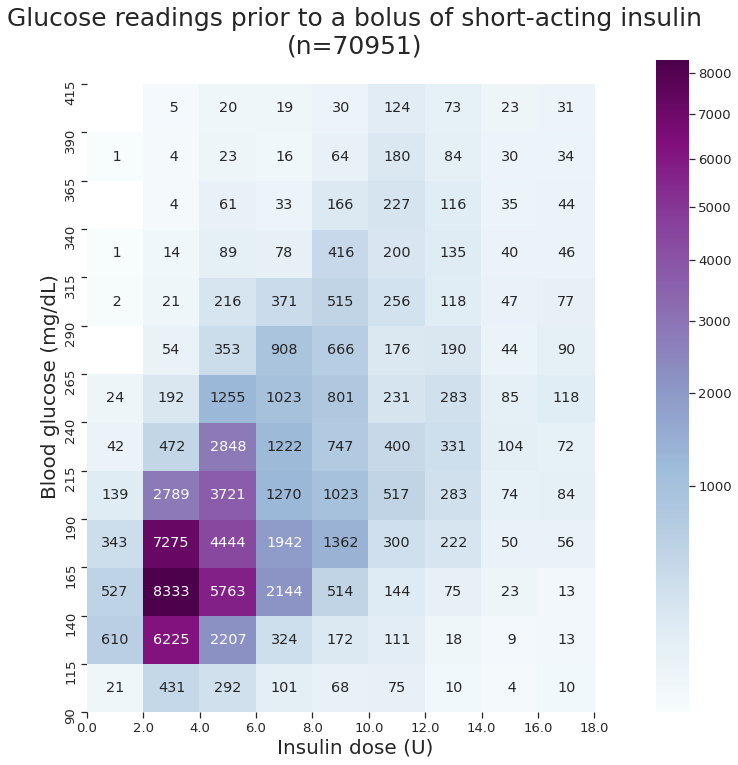

In [ ]:
warnings.simplefilter('ignore')

# From Part1 Notebook
P99_bol_s = 18.0

# Heatmap
short_BOL_heat = short_BOL_adjusted.dropna(subset=['GLC_AL']).copy()
short_BOL_heat['A'] = ((short_BOL_heat['GLCTIMER_AL'] - 
              short_BOL_heat['STARTTIME'])/pd.Timedelta('1 minute'))*60
short_BOL_heat=short_BOL_heat.set_index('A')

#Define the cell size on the heat map
glc_base=25
ins_base=2

#Define heatmap limits
xlow=0
xhigh=P99_bol_s
ylow=90
yhigh=400
xhigh-=ins_base

#create categories for constructing the heatmap
short_BOL_heat['glc_cat']=(short_BOL_heat['GLC_AL'].apply(
        lambda x: myround(x, glc_base))/glc_base)
short_BOL_heat['ins_cat']=(short_BOL_heat['INPUT'].apply(
        lambda x: myround(x, ins_base))/ins_base)

#create dataframe for the heatmap using pivot_table
heat_df=pd.pivot_table(short_BOL_heat, values='ICUSTAY_ID', index=['glc_cat']
, columns=['ins_cat'], aggfunc='count')
#trim the heatmap dataframe based on the lmits specificed
heat_df=heat_df.loc[ylow/glc_base:yhigh/glc_base:,xlow/ins_base:xhigh/ins_base:]

#create labels for the x and y ticks
heat_xtick=np.arange(xlow, xhigh+ins_base*2, ins_base)
heat_ytick=np.arange(ylow, yhigh+glc_base*1, glc_base)

#plot heatmap
sns.set(style="ticks", font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax=sns.heatmap(heat_df, robust=True, annot=True, cmap="BuPu", fmt="2.0f"
               , xticklabels=heat_xtick, yticklabels=heat_ytick
               , norm=colors.PowerNorm(gamma=1./2.))

#titles
plt.title(f"Glucose readings prior to a bolus of short-acting insulin\n(n={int(heat_df.sum().values.sum())})", 
          fontsize=25)
plt.ylabel("Blood glucose (mg/dL)", fontsize=20)
plt.xlabel("Insulin dose (U)", fontsize=20)

#invert axis and offset labels
ax.invert_yaxis()
ax.set_yticks(np.arange(0, ((yhigh-ylow)/glc_base)+1))
ax.set_xticks(np.arange(0, ((xhigh-xlow)/ins_base)+2))

# Save figure, uncomment if needed.
fig.savefig(base_dir+'/DataExtraction/ShortBolusHeatMap.png', bbox_inches='tight',
            dpi=fig.dpi)

### Infusions of short-acting insulin

In [ ]:
warnings.simplefilter('default')

# Filtering for only short insulin infusions and all sources of glucose
short_INF_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Short") & 
        (ICUinputs_adjusted['EVENT'].str.contains('INFUSION'))].copy()

# Get statistics
display(HTML('<h5>Counts</h5>'))
print("Entries:             {}".format(short_INF_adjusted.shape[0]))
print("Patients:            {}".format(short_INF_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_INF_adjusted['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(short_INF_adjusted['ICUSTAY_ID'].nunique()))

display(short_INF_adjusted[['INPUT_HRS','GLC_AL']].describe())

Entries:             44631
Patients:            3607
Hospital admissions: 3813
ICU stays:           3859


,INPUT_HRS,GLC_AL
count,44631.000000,34660.000000
mean,4.985731,166.919388
std,4.164922,74.130262
min,0.003418,90.000000
25%,2.000681,122.000000
50%,4.000000,145.000000
75%,6.006279,184.000000
max,29.812108,847.000000


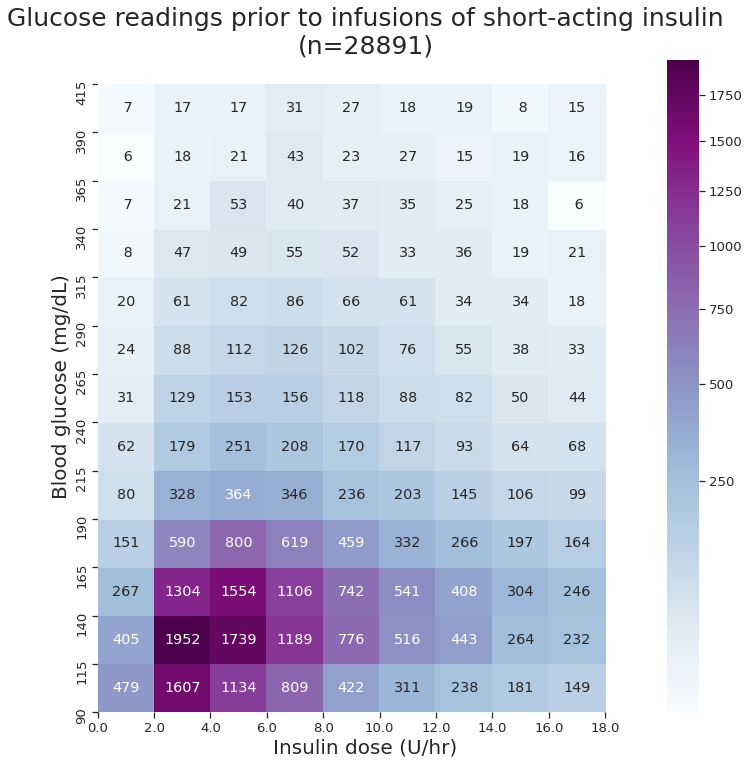

In [ ]:
warnings.simplefilter('ignore')

# Heatmap
short_INF_heat = short_INF_adjusted.dropna(subset=['GLC_AL']).copy()
short_INF_heat['A'] = ((short_INF_heat['GLCTIMER_AL'] - 
              short_INF_heat['STARTTIME'])/pd.Timedelta('1 minute'))*60
short_INF_heat=short_INF_heat.set_index('A')

#Define the cell size on the heat map
glc_base=25
ins_base=2

#Define heatmap limits
xlow=0
xhigh=P99_bol_s
ylow=90
yhigh=400
xhigh-=ins_base

#create categories for constructing the heatmap
short_INF_heat['glc_cat']=(short_INF_heat['GLC_AL'].apply(
        lambda x: myround(x, glc_base))/glc_base)
short_INF_heat['ins_cat']=(short_INF_heat['INPUT'].apply(
        lambda x: myround(x, ins_base))/ins_base)

#create dataframe for the heatmap using pivot_table
heat_df_i=pd.pivot_table(short_INF_heat, values='ICUSTAY_ID', index=['glc_cat']
, columns=['ins_cat'], aggfunc='count')
#trim the heatmap dataframe based on the lmits specificed
heat_df_i=heat_df_i.loc[ylow/glc_base:yhigh/glc_base:,xlow/ins_base:xhigh/ins_base:]

#create labels for the x and y ticks
heat_xtick=np.arange(xlow, xhigh+ins_base*2, ins_base)
heat_ytick=np.arange(ylow, yhigh+glc_base*1, glc_base)

#plot heatmap
sns.set(style="ticks", font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax=sns.heatmap(heat_df_i, robust=True, annot=True, cmap="BuPu", fmt="2.0f"
               , xticklabels=heat_xtick, yticklabels=heat_ytick
               , norm=colors.PowerNorm(gamma=1./2.))

#titles
plt.title(f"Glucose readings prior to infusions of short-acting insulin\n(n={int(heat_df_i.sum().values.sum())})", 
          fontsize=25)
plt.ylabel("Blood glucose (mg/dL)", fontsize=20)
plt.xlabel("Insulin dose (U/hr)", fontsize=20)

#invert axis and offset labels
ax.invert_yaxis()
ax.set_yticks(np.arange(0, ((yhigh-ylow)/glc_base)+1))
ax.set_xticks(np.arange(0, ((xhigh-xlow)/ins_base)+2))

# Save figure, uncomment if needed.
fig.savefig(base_dir+'/DataExtraction/ShortInfxnHeatMap.png', 
            bbox_inches='tight',dpi=fig.dpi)

### Boluses of intermediate-acting insulin

In [ ]:
warnings.simplefilter('default')

# Filtering for only short insulin infusions and all sources of glucose
inter_BOL_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Intermediate") & 
        (ICUinputs_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(inter_BOL_adjusted.shape[0]))
print("Patients:            {}".format(inter_BOL_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(inter_BOL_adjusted['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(inter_BOL_adjusted['ICUSTAY_ID'].nunique()))

display(inter_BOL_adjusted[['INPUT','GLC_AL']].describe())

Entries:             3962
Patients:            680
Hospital admissions: 781
ICU stays:           813


,INPUT,GLC_AL
count,3962.000000,971.000000
mean,18.572438,172.649846
std,15.330288,66.466556
min,1.000000,90.000000
25%,8.000000,126.500000
50%,15.000000,151.000000
75%,25.000000,202.000000
max,180.000000,481.000000


In [ ]:
# Aligned and not aligned entries
display(HTML('<h2>Boluses entries of intermediate-acting insulin<h2>'))
print("Entries that were aligned: {}".format(
    inter_BOL_adjusted.shape[0]-inter_BOL_adjusted.loc[np.isnan(
        inter_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Entries that weren't aligned: {}".format(
    inter_BOL_adjusted.loc[np.isnan(inter_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Non-paired percentage: {:0.2f}%".format(
    inter_BOL_adjusted.loc[np.isnan(
        inter_BOL_adjusted.RULE),'RULE'].shape[0]/inter_BOL_adjusted.shape[0]*100))

Entries that were aligned: 964
Entries that weren't aligned: 2998
Non-paired percentage: 75.67%


### Boluses of long-acting insulin

In [ ]:
warnings.simplefilter('default')

# Filtering for only short insulin infusions and all sources of glucose
long_BOL_adjusted = ICUinputs_adjusted[
        (ICUinputs_adjusted['INSULINTYPE']=="Long") & 
        (ICUinputs_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries:             {}".format(long_BOL_adjusted.shape[0]))
print("Patients:            {}".format(long_BOL_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(long_BOL_adjusted['HADM_ID'].nunique()))
print('ICU stays:           {}'.format(long_BOL_adjusted['ICUSTAY_ID'].nunique()))

display(long_BOL_adjusted[['INPUT','GLC_AL']].describe())

Entries:             8625
Patients:            2908
Hospital admissions: 3314
ICU stays:           3408


,INPUT,GLC_AL
count,8625.000000,2961.000000
mean,23.378214,153.588990
std,16.144536,64.972829
min,1.000000,90.000000
25%,10.000000,111.000000
50%,20.000000,130.000000
75%,30.000000,175.000000
max,180.000000,543.000000


In [ ]:
# Aligned and not aligned entries
display(HTML('<h2>Boluses entries of long-acting insulin<h2>'))
print("Entries that were aligned: {}".format(
    long_BOL_adjusted.shape[0]-long_BOL_adjusted.loc[np.isnan(
        long_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Entries that weren't aligned: {}".format(
    long_BOL_adjusted.loc[np.isnan(long_BOL_adjusted.RULE),'RULE'].shape[0]))
print("Non-paired percentage: {:0.2f}%".format(
    long_BOL_adjusted.loc[np.isnan(
        long_BOL_adjusted.RULE),'RULE'].shape[0]/long_BOL_adjusted.shape[0]*100))

Entries that were aligned: 2933
Entries that weren't aligned: 5692
Non-paired percentage: 65.99%


## Non-adjusted datasets
To complement this analysis, and to show the difference between implementing and not implementing the proposed rules, three cohorts were created: a) no pairing rules applied, b) paired a glucose reading recorded within 60 minutes of the insulin event instead of 90 minutes, and c) pairing a glucose reading.


### Scenario C
Glucose readings CURATED and insulin inputs CURATED but NO RULES

* **Note 1**: Add the name of your dataset hosted in BigQuery (Line 45). 
* **Note 2**: The table `glucose_insulin_ICU` was created in `1.0-ara-pairing-I.ipynb` notebook. It is equivalent to `glucose_insulin_ICU.csv`.

In [ ]:
# GLUCOSE READINGS CURATED AND INSULIN INPUTS CURATED but no RULES

query = """
SELECT pg.*
        , (CASE
                WHEN pg.GLCSOURCE_AL IS null 
                AND (LEAD(pg.GLCTIMER_AL,1) OVER(PARTITION BY pg.ICUSTAY_ID ORDER BY pg.TIMER) = pg.GLCTIMER)
                THEN 1 
                WHEN pg.GLCSOURCE_AL IS null 
                AND (LAG(pg.GLCTIMER_AL,1) OVER(PARTITION BY pg.ICUSTAY_ID ORDER BY pg.timer) = pg.GLCTIMER)
                AND LAG(endtime,1) OVER(PARTITION BY ICUSTAY_ID ORDER BY timer) IS NOT null 
                THEN 1
                ELSE null END) AS Repeated
        FROM(SELECT p1.* 
        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN (LAG(p1.GLC,1) OVER(w))
            ELSE null END
            ) AS GLC_AL

        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN (LAG(p1.TIMER,1) OVER(w))
            ELSE null END
            ) AS GLCTIMER_AL

        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN (LAG(p1.GLCSOURCE,1) OVER(w))
            ELSE null END
            ) AS GLCSOURCE_AL
        , (CASE
            -- Select the previous glucose value regardless the time distance
            WHEN p1.EVENT IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK') 
            THEN 1
            ELSE null END
            ) AS RULE
        FROM `your_dataset.glucose_insulin_ICU` AS p1
        WINDOW w AS(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
        ) AS pg
"""

glc_curALins_cur = q(query,projectid)

qwe = glc_curALins_cur[(glc_curALins_cur['INSULINTYPE']=="Short") & 
        (glc_curALins_cur['EVENT'].str.contains('BOLUS'))].copy()

display(HTML('<h4>Statistics for both glucose readings and insulin inputs CURATED</h4>'))
print("Total entries: {}".format(glc_curALins_cur.shape[0]))
display(qwe[['INPUT','GLC_AL']].describe())

display(HTML('<h5>Contains the following information (only for short-acting)</h5>'))
print("Boluses of short-acting insulin: {}".format(qwe.shape[0]))
print("Patients: {} out of {}".format(qwe['SUBJECT_ID'].nunique(),
                                      glc_curALins_cur['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(qwe['HADM_ID'].nunique()))
print('ICU stays: {}'.format(qwe['ICUSTAY_ID'].nunique()))

# Rules
display(HTML('<h5>Frequency of the rules</h5>'))
print(qwe['RULE'].value_counts())

# Save as CSV file, uncomment and modify as needed.
# qwe.to_csv(base_dir+"/DataExtraction/BolusesCUR_nr.csv", index=False,
#           encoding='utf8', header = True)

del query,qwe

/usr/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <ssl.SSLSocket fd=63, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 52706), raddr=('74.125.142.95', 443)>
  obj, end = self.scan_once(s, idx)
/usr/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 52660), raddr=('74.125.20.95', 443)>
  obj, end = self.scan_once(s, idx)


Total entries: 603764


,INPUT,GLC_AL
count,88460.000000,78881.000000
mean,4.517858,183.012436
std,3.038148,58.240480
min,0.100000,2.000000
25%,2.000000,145.000000
50%,4.000000,169.000000
75%,6.000000,207.000000
max,17.000000,901.000000


Boluses of short-acting insulin: 88460
Patients: 9370 out of 9518
Hospital admissions: 10877
ICU stays: 11484


1.0    78881
Name: RULE, dtype: int64


### Scenario B
Glucose reading CURATED and inulin inputs CURATED paired with rules (60 min)

* **Note 1**: Substitute `your_dataset` with the name of your dataset ID (Line 849) where you hosted/stored the tables created in the `1.0-ara-pairing-I.ipynb` notebook. 
* **Note 2**: The table `glucose_insulin_ICU` was created in `1.0-ara-pairing-I.ipynb` notebook. It is equivalent to `glucose_insulin_ICU.csv`.

In [ ]:
# Import dataset adjusted or aligned with 60 min

query ="""
WITH pg AS(
    SELECT p1.*

    -- Column GLC_AL that would gather paired glucose values according to the proposed rules
    ,(CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings, select the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                    ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                    ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                    )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLC,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another insulin event
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLC,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the POSTERIOR glucose (1 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLC,1) OVER(w))

        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLC_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column GLCTIMER_AL that would gather the timestamp of the paired glucose reading
    , (CASE 
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.TIMER,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.TIMER,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.TIMER,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the timestamp of the POSTERIOR glucose (1 rows below) measurement that gathers the 
        -- previous conditions
        THEN (LEAD(p1.TIMER,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCTIMER_AL

    -- -----------------------------------------------------------------------------------------------
    -- Column GLCSOURCE_AL that would indicate whether is fingerstick or lab analyzer sample of 
    -- the paired glucose reading
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN (LAG(p1.GLCSOURCE,2) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w)) 
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,2) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN (LAG(p1.GLCSOURCE,1) OVER(w))

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the whether is figerstick or lab analyzer the POSTERIOR glucose (1 rows below) measurement 
        -- that gathers the previous conditions
        THEN (LEAD(p1.GLCSOURCE,1) OVER(w))

        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS GLCSOURCE_AL

    -- ---------------------------------------------------------------------------------------------
    -- Column RULE that indicateS which pairing rule is applied for the i^th case
    , (CASE
        -- 1ST CLAUSE
        -- When previous and following rows are glucose readings,vselect the glucose value that 
        -- has the shortest time distance to insulin bolus/infusion.

            -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding and posterior glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Posterior glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
            AND ( -- Preceding glucose
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 2ND CLAUSE
        -- In case the posterior glucose reading is higher than the preceding
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding and posterior glucose measurements
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Time-gap between glucose and insulin, should be equal or less than 90 minutes
                -- Preceding glucose
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
                -- Posterior glucose
            AND ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose values is higher than the preceding glucose
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,1) OVER(w) 
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 3
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 3RD CLAUSE
        -- When previous timestamp is an insulin bolus/infusion event
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above and regular insulin
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND (LAG(p1.INSULINTYPE,2) OVER(w)) IN('Short')
            -- One row above there is another insulin event
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a shortime or equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Preceding glucose 2 rows above is equal or greater than 90 min
            AND (LAG(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose value is lower than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) >= LEAD(p1.GLC,1) OVER(w)
        -- Return the preceding glucose value 2 rows above
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 4TH CLAUSE
        -- When previous timestamp is for Insulin bolus/infusion but posterior glucose
        -- is higher than the preceding glucose 2 rows above.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 2 rows above
            AND (LAG(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row above there is another regular insulin
            AND (LAG(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LAG(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,1) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
            -- Posterior glucose value is higher than the preceding glucose 2 rows above
            AND LAG(p1.GLC,2) OVER(w) < LEAD(p1.GLC,1) OVER(w)
        -- Return the POSTERIOR glucose measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 5TH CLAUSE
        -- When posterior timestamp is for Insulin bolus/infusion but preceding is glucose
        -- and there is a glucose 2 rows below.

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a shorter OR equal time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Preceding glucose reading is greater or equal to 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
            -- Preceding glucose 2 rows above occured up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is lower than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) >= LEAD(p1.GLC,2) OVER(w)
        -- Return the PRECEDING glucose (1 row above) measurement that gathers the previous conditions
        THEN 4
        
        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 6TH CLAUSE
        -- When posterior glucose reading (2 rows below) is higher than preceding glucose.
        
        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 2 rows below
            AND (LEAD(p1.GLCSOURCE,2) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- One row BELOW there is another regular insulin
            AND (LEAD(p1.EVENT,1) OVER(w)) IN('BOLUS_INYECTION','BOLUS_PUSH','INFUSION')
            AND (LEAD(p1.INSULINTYPE,1) OVER(w)) IN('Short')
            AND ( -- Preceding glucose has a longer time-gap to insulin than the posterior
                ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 
                ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,2) OVER(w)), p1.TIMER, MINUTE))
                )
            -- Posterior glucose reading is greater or equal to 90 mg/dL
            AND (LEAD(p1.GLC,2) OVER(w)) >= 90
            -- Posterior glucose (2 rows below) occurs within 90 minutes
            AND ABS(TIMESTAMP_DIFF(LEAD(p1.timer,2) OVER(w), p1.timer, MINUTE)) <= 60
            -- Preceding glucose 1 row above occures up to 90 minutes before
            AND ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60
            -- Posterior glucose value (2 rows below) is higher than the preceding glucose 1 row above
            AND LAG(p1.GLC,1) OVER(w) < LEAD(p1.GLC,2) OVER(w)
        -- Return the POSTERIOR glucose (2 rows below) measurement that gathers the previous conditions
        THEN 4

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 7TH CLAUSE
        -- When it is the last insulin dose and record in an ICU stay

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Identify preceding glucose reading
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin, should be equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Preceding glucose should be equal or greater than 90 mg/dL
            AND (LAG(p1.GLC,1) OVER(w)) >= 90
        -- Return the PRECEDING glucose measurement that gathers the previous conditions
        THEN 1

        -- %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        -- 8TH CLAUSE
        -- When there is no preceding glucose reading within 90 min, but there is a posterior 
        -- glucose within 90 min

        -- Identify an insulin event either bolus or infusion
        WHEN p1.EVENT IN('BOLUS_INYECTION', 'BOLUS_PUSH', 'INFUSION')
            -- Regular insulin or short-acting
            AND p1.INSULINTYPE IN('Short')
            -- Identify preceding glucose reading 1 row above
            AND (LAG(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Identify posterior glucose reading 1 row below
            AND (LEAD(p1.GLCSOURCE,1) OVER(w)) IN('BLOOD', 'FINGERSTICK')
            -- Time-gap between preceding glucose and insulin is greater than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LAG(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) > 90)
            -- Time-gap between posterior glucose and insulin is equal or less than 90 minutes
            AND (ABS(TIMESTAMP_DIFF((LEAD(p1.TIMER,1) OVER(w)), p1.TIMER, MINUTE)) <= 60)
            -- Posterior glucose should be equal or greater than 90 mg/dL
            AND (LEAD(p1.GLC,1) OVER(w)) >= 90
        -- Return the Rule number applied
        THEN 2
        
        -- Otherwise, return null value and finish CASE clause
        ELSE null END
    ) AS RULE

    FROM `your_dataset.glucose_insulin_ICU` AS p1
    WINDOW w AS(PARTITION BY CAST(p1.HADM_ID AS INT64) ORDER BY p1.TIMER)
)

-- Create a colum that identifies the glucose readings were paired and are duplicated in pg
SELECT pg.*
, (CASE
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LEAD(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          THEN 1 
          WHEN pg.GLCSOURCE_AL IS null 
          AND (LAG(pg.GLCTIMER_AL,1) OVER(x) = pg.GLCTIMER)
          AND LAG(endtime,1) OVER(x) IS NOT null 
          THEN 1
          ELSE null END) AS Repeated
FROM pg
WINDOW x AS(PARTITION BY ICUSTAY_ID ORDER BY pg.timer)
"""

ICU60min_adjusted = q(query,projectid)

del query

# Convert dtypes
ICU60min_adjusted[["Repeated","INFXSTOP","RULE"]] = ICU60min_adjusted[
        ["Repeated","INFXSTOP","RULE"]].apply(pd.to_numeric, errors='coerce')

# Remove values that are repeated due to the SQL query
ICU60min_adjusted = ICU60min_adjusted[ICU60min_adjusted['Repeated']!=1]

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(ICU60min_adjusted.shape[0]))
print("Patients: {}".format(ICU60min_adjusted['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(ICU60min_adjusted['HADM_ID'].nunique()))
print('ICU stays: {}'.format(ICU60min_adjusted['ICUSTAY_ID'].nunique()))

# Rules
display(HTML('<h5>Frequency of the rules</h5>'))
print(ICU60min_adjusted['RULE'].value_counts())

/usr/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 52770), raddr=('74.125.20.95', 443)>
  obj, end = self.scan_once(s, idx)
/usr/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <ssl.SSLSocket fd=79, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('172.28.0.2', 53808), raddr=('74.125.195.95', 443)>
  obj, end = self.scan_once(s, idx)


Entries: 504337
Patients: 9518
Hospital admissions: 11094
ICU stays: 12210


1.0    80167
2.0     8544
4.0     7932
3.0     4630
Name: RULE, dtype: int64


#### Boluses of short-acting insulin

In [ ]:
# Filtering for only short insulin boluses and all sources of glucose
short_BOL_60 = ICU60min_adjusted[(ICU60min_adjusted['INSULINTYPE']=="Short") & 
                                 (ICU60min_adjusted['EVENT'].str.contains('BOLUS'))].copy()

# Get statistics
display(HTML('<h5>Contains the following information</h5>'))
print("Entries: {}".format(short_BOL_60.shape[0]))
print("Patients: {}".format(short_BOL_60['SUBJECT_ID'].nunique()))
print("Hospital admissions: {}".format(short_BOL_60['HADM_ID'].nunique()))
print('ICU stays: {}'.format(short_BOL_60['ICUSTAY_ID'].nunique()))

display(short_BOL_60[['INPUT','GLC_AL']].describe())

# Save as CSV file, uncomment and modify as needed.
# short_BOL_60.to_csv(base_dir+"/DataExtraction/BolusesCUR_60.csv", index=False,
#                    encoding='utf8', header = True)

Entries: 88460
Patients: 9370
Hospital admissions: 10877
ICU stays: 11484


,INPUT,GLC_AL
count,88460.000000,64925.000000
mean,4.517858,187.696388
std,3.038148,58.146626
min,0.100000,90.000000
25%,2.000000,150.000000
50%,4.000000,173.000000
75%,6.000000,211.000000
max,17.000000,901.000000


# End